In [1]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats
import random
from pathlib import Path
from random import randrange
import pandas as pd

In [2]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

2023-02-15 13:16:37.663112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 13:16:37.812523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aayush/git/rl_recsys/.venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-15 13:16:37.812556: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 13:16:38.672070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.

In [3]:
class LTSDocument(document.AbstractDocument):
    def __init__(
        self,
        doc_id,
        year,
        name,
        artists,
        popularity,
        valence,
        song_id,
        danceability,
        loudness,
        speechiness,
        acousticness,
        liveness,
        label,
    ): 
        self.year = year
        self.name = name
        self.artists = artists
        self.popularity = popularity
        self.valence = valence
        self.song_id = song_id
        self.danceability = danceability
        self.loudness = loudness
        self.speechiness=speechiness
        self.acousticness = acousticness
        self.liveness = liveness
        self.label = label

        # doc_id is an integer representing the unique ID of this document
        super(LTSDocument, self).__init__(doc_id)

    def create_observation(self):
        return self.label
        
        # return np.array([self.genre])

    @staticmethod
    def observation_space():
        return spaces.Discrete(10)
        # return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)

    def __str__(self):
        #return f"{self._doc_id}"
        return "Music {} with loc {} year {} name {}.".format(
            self._doc_id,
            self.year,
            self.name,
            self.artists,
            self.popularity,
            self.valence,
            self.song_id,
            self.danceability,
            self.loudness,
            self.speechiness,
            self.acousticness,
            self.liveness,
            self.label,
        )

In [4]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
    DATASET_NAME = "Spotify"
    _DATA_PATH = Path(Path.home() / "rsys_data")
    _DATASET_PATH = _DATA_PATH / DATASET_NAME
    songs = pd.read_feather(_DATASET_PATH)

    def __init__(self, doc_ctor=LTSDocument, **kwargs):
        super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
        self._music_count = 0

    def sample_document(self, songs=songs):
        s = randrange(len(songs.index))
        doc_features={}
        doc_features["doc_id"] = self._music_count
        doc_features["year"]=songs.loc[[s]].year
        doc_features["name"]=songs.loc[[s]].name
        doc_features["artists"]=songs.loc[[s]].artists
        doc_features["popularity"]=songs.loc[[s]].popularity
        doc_features["valence"]=songs.loc[[s]].valence
        doc_features["song_id"]=songs.loc[[s]].song_id
        doc_features["danceability"]=songs.loc[[s]].danceability
        doc_features["acousticness"]=songs.loc[[s]].acousticness
        doc_features["liveness"]=songs.loc[[s]].liveness
        doc_features["label"]=songs.loc[[s]].label
        doc_features["loudness"]=songs.loc[[s]].loudness
        doc_features["speechiness"]=songs.loc[[s]].speechiness
        self._music_count += 1
        return self._doc_ctor(**doc_features)

In [5]:
sampler = LTSDocumentSampler()
for i in range(10): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Music 0 with loc 156175    1948
Name: year, dtype: int64 year 156175    Asoon Karamaty
Name: name, dtype: object name 156175    ['Umm Kulthum']
Name: artists, dtype: object.
Music 1 with loc 938    1926
Name: year, dtype: int64 year 938    Big Butter And Egg Man
Name: name, dtype: object name 938    ['Louis Armstrong & His Hot Five']
Name: artists, dtype: object.
Music 2 with loc 93269    1940
Name: year, dtype: int64 year 93269    T'asimenia soy tsaprakia
Name: name, dtype: object name 93269    ['Dimitris Atraidis']
Name: artists, dtype: object.
Music 3 with loc 141767    1948
Name: year, dtype: int64 year 141767    El amor brujo "Ballet-pantomime": 9. Escena
Name: name, dtype: object name 141767    ['Manuel de Falla', 'Fritz Reiner', 'Pittsburg...
Name: artists, dtype: object.
Music 4 with loc 147659    1980
Name: year, dtype: int64 year 147659    Love Me Again
Name: name, dtype: object name 147659    ['Patti Austin']
Name: artists, dtype: object.
Music 5 with loc 90267    2010
Name:

In [6]:
class LTSUserState(user.AbstractUserState):
    def __init__(
        self,
        age,
        gender,
        valence,
        danceability,
        loudness,
        speechiness,
        acousticness,
        liveness,
        net_genre_exposure,
        sensitivity,
        time_budget,
        label,
        mode,
        key,
        duration_ms,
        tempo,
        energy,
        instrumentalness,
        observation_noise_stddev=0.1,
    ):
        ## Transition model parameters
        ## State variables
        ##############################
        self.age = age
        self.gender = gender
        self.sensitivity = sensitivity
        self.valence = valence
        self.danceability = danceability

        ## Engagement parameters
        self.loudness = loudness
        self.speechiness = speechiness
        self.acousticness = acousticness
        self.liveness = liveness

        self.label = label
        self.mode = mode
        self.key = key
        self.duration_ms = duration_ms
        self.tempo = tempo
        self.energy = energy
        self.instrumentalness = instrumentalness
        self.net_genre_exposure = net_genre_exposure
        self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_genre_exposure))
        self.time_budget = time_budget

        # Noise
        self._observation_noise = observation_noise_stddev

    def create_observation(self):
        """User's state is not observable."""
        clip_low, clip_high = (
            -1.0 / (1.0 * self._observation_noise),
            1.0 / (1.0 * self._observation_noise),
        )
        noise = stats.truncnorm(
            clip_low, clip_high, loc=0.0, scale=self._observation_noise
        ).rvs()
        noisy_sat = self.satisfaction + noise
        return np.array(
            [
                noisy_sat,
            ]
        )

    @staticmethod
    def observation_space():
        return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)

    # scoring function for use in the choice model -- the user is more likely to
    # click on more chocolatey content.
    def score_document(self, doc_obs):
        return 1 - doc_obs


In [7]:
class LTSStaticUserSampler(user.AbstractUserSampler):
    _state_parameters = None

    def __init__(
        self,
        user_ctor=LTSUserState,
        sensitivity=0.01,
        time_budget=30,
        #  age=np.random.random_integers(20,60),
        #  gender=np.random.random_integers(1),
        #  valence=np.random.uniform(0.0,1.0),
        #  danceability=np.random.normal(0.5373955347986852,0.17613721955546152),
        #  loudness=np.random.gumbel(0.8004193058243345,0.0690033070151354),
        #  speechiness=np.random.laplace(0.045,0.06335336735949558),
        #  acousticness=np.random.uniform(0.0,0.996),
        #  liveness=np.random.laplace(0.136,0.11092283130094402),
        #  mood=np.random.random_integers(3),
        **kwargs
    ):
        self._state_parameters = {
            "sensitivity": sensitivity,
            "time_budget": time_budget,
        }  #'age' : age,
        #                           'gender_group' : gender_group,
        #                           'valence': valence,
        #                           'danceability': danceability,
        #                           'loudness': loudness,
        #                           'speechiness': speechiness,
        #                           'acousticness': acousticness,
        #                           'liveness': liveness,
        #                           'mood': mood

        super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

    def sample_user(self):
        self._state_parameters["age"] = np.random.random_integers(20, 60)
        self._state_parameters["gender"] = np.random.random_integers(2)
        self._state_parameters["valence"] = np.random.uniform(0.0, 1.0)
        self._state_parameters["danceability"] = np.random.normal(
            0.5373955347986852, 0.17613721955546152
        )
        self._state_parameters["loudness"] = np.random.gumbel(
            0.8004193058243345, 0.0690033070151354
        )
        self._state_parameters["speechiness"] = np.random.laplace(
            0.045, 0.06335336735949558
        )
        self._state_parameters["acousticness"] = np.random.uniform(0.0, 0.996)
        self._state_parameters["liveness"] = np.random.laplace(
            0.136, 0.11092283130094402
        )
        self._state_parameters["label"] = np.random.random_integers(4)
        self._state_parameters["mode"] = np.random.random_integers(2)
        self._state_parameters["key"] = np.random.random_integers(12)
        self._state_parameters["duration_ms"] = np.random.laplace(
            207467.0, 69419.7225773939
        )
        self._state_parameters["tempo"] = np.random.gumbel(
            102.26991914996023, 27.79478925686645
        )
        self._state_parameters["energy"] = np.random.uniform(0.0, 1.0)
        self._state_parameters["instrumentalness"] = np.random.exponential(0.167)

        starting_nke = self._rng.random_sample() - 0.5
        self._state_parameters["net_genre_exposure"] = starting_nke
        # starting_nke = ((self._rng.random_sample() - .5) *
        #                 (1 / (1.0 - self._state_parameters['memory_discount'])))
        # self._state_parameters['net_genre_exposure'] = starting_nke
        return self._user_ctor(**self._state_parameters)


/tmp/ipykernel_4003538/3710956579.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_4003538/3710956579.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_4003538/3710956579.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_4003538/3710956579.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)


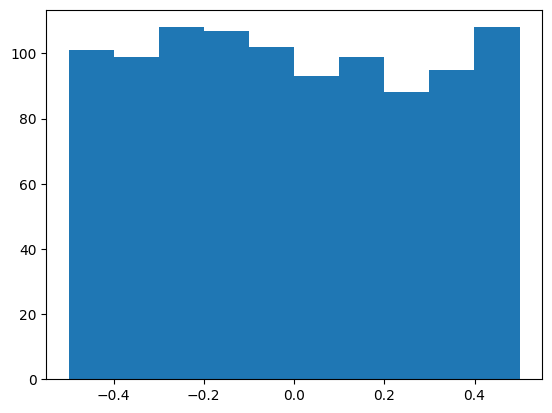

In [8]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_genre_exposure)
_ = plt.hist(starting_nke)

In [9]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

In [10]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})

In [11]:

def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  session_engagement=0
  session_items=[]
  individual_reward=[]
  # Populate clicked item.
  for i in range(0, len(slate_documents)):
    k=self._generate_response(slate_documents[i], responses[i])
    p=k.index.tolist()
    session_items.append(p[0])
    session_engagement+=k.values
    m=k.values.tolist()
    individual_reward.append(m[0])
  print()
  

  # self._generate_response(slate_documents[selected_index],
  #                         responses[selected_index])
  user_information=[self._user_state.age, self._user_state.gender, self._user_state.acousticness, self._user_state.liveness, self._user_state.danceability, self._user_state.valence, self._user_state.label]
  print(user_information)
  print(session_items)
  print(individual_reward)
  print(session_engagement)
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and kale.
  if (self._user_state.age>40):
    engagement =((doc.acousticness-self._user_state.acousticness)+(doc.liveness-self._user_state.liveness)) + (doc.label - self._user_state.label)
    engagement_loc = 1/abs(((doc.acousticness-self._user_state.acousticness)+(doc.liveness-self._user_state.liveness)))
    engagement_loc *= self._user_state.satisfaction
    engagement_scale = (doc.acousticness * (self._user_state.label+1)
                      + ((1 - doc.liveness)
                          * (self._user_state.label+1)))
  else:
    engagement = (doc.danceability-self._user_state.danceability)+(doc.valence-self._user_state.valence) + (doc.label - self._user_state.label)
    engagement_loc = 1/abs((doc.danceability-self._user_state.danceability)+(doc.valence-self._user_state.valence))
    engagement_loc *= self._user_state.satisfaction
    engagement_scale = (doc.danceability* (self._user_state.label+1)
                      + ((1 - doc.valence)
                          * (self._user_state.label+1)))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)

  
  response.engagement = np.ceil(engagement)
  return engagement

def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      label = np.random.normal(scale=self._user_state.label)
      net_genre_exposure = (self._user_state.valence
                                * self._user_state.danceability
                                + 2.0 * (doc.danceability - 0.5)
                                + label
                              )
      self._user_state.net_genre_exposure = net_genre_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.label
                                        * net_genre_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

In [12]:
DATASET_NAME = "Spotify"
_DATA_PATH = Path(Path.home() / "rsys_data")
_DATASET_PATH = _DATA_PATH / DATASET_NAME
songs = pd.read_feather(_DATASET_PATH)
print(songs.dtypes)
songs.loc[[111930]]

year                  int64
name                 object
artists              object
popularity            int64
valence             float64
song_id              object
danceability        float64
loudness            float64
speechiness         float64
acousticness        float64
liveness            float64
label                 int32
key                   int64
mode                  int64
tempo               float64
instrumentalness    float64
energy              float64
duration_ms           int64
dtype: object


,year,name,artists,popularity,valence,song_id,danceability,loudness,speechiness,acousticness,liveness,label,key,mode,tempo,instrumentalness,energy,duration_ms
111930,1955,I Can't Believe You're In Love With Me,['Oscar Peterson'],3,0.375,2wG4hK6jTtEcC3A3MiBRs6,0.778,0.659494,0.0588,0.987,0.103,2,5,0,119.552,0.851,0.111,214423


In [13]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0

In [14]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

In [15]:
slate_size = 10
num_candidates = 10
ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)

/tmp/ipykernel_4003538/3710956579.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_4003538/3710956579.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_4003538/3710956579.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_4003538/3710956579.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)


In [16]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    # if response.clicked:
    reward += response.engagement
  return reward

In [17]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [18]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['music_id ' + key + " index " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [i for i in range(0,10)]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['music_id ' + key + " index " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
music_id 10 index 29193    3
Name: label, dtype: int32
music_id 11 index 59283    2
Name: label, dtype: int32
music_id 12 index 39631    1
Name: label, dtype: int32
music_id 13 index 105392    3
Name: label, dtype: int32
music_id 14 index 29691    3
Name: label, dtype: int32
music_id 15 index 121149    2
Name: label, dtype: int32
music_id 16 index 150314    3
Name: label, dtype: int32
music_id 17 index 158155    2
Name: label, dtype: int32
music_id 18 index 3898    1
Name: label, dtype: int32
music_id 19 index 23949    2
Name: label, dtype: int32
Noisy user state observation
[0.4923347]

[46, 2, 0.11639640196130986, 0.15793495556523526, 0.22138800459126706, 0.8863682243998481, 2]
[29193, 59283, 39631, 105392, 29691, 121149, 150314, 158155, 3898, 23949]
[1.1086686424734549, 0.8476686424734549, -0.40633135752654503, 1.4786686424734548, 1.1959686424734548, 0.8526686424734549, 1.128568642473455, 0.8616686424734549, 0.10866864247345487, 0.9906686424734549]


/tmp/ipykernel_4003538/3710956579.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_4003538/3710956579.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_4003538/3710956579.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_4003538/3710956579.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)


In [19]:
def slate_score(lts_gym_env):
    observation_0 = lts_gym_env.reset()

    doc_strings = ['music_id ' + key + " index " + str(value) for key, value
                in observation_0['doc'].items()]
    recommendation_slate_0 = [i for i in range(0,10)]
    for i in range(0,10):
        observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)

slate_score(lts_gym_env)

/tmp/ipykernel_4003538/3710956579.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_4003538/3710956579.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_4003538/3710956579.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_4003538/3710956579.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)



[47, 1, 0.8626169971887727, 0.13552291653955129, 0.3185554956527496, 0.7023088912853874, 1]
[68804, 92568, 95404, 42567, 162507, 119310, 153611, 11706, 37818, 45499]
[1.1136500862716758, 1.096860086271676, 1.162860086271676, -0.05213991372832405, 1.1255600862716761, -0.296139913728324, -0.23213991372832404, 1.240060086271676, 1.090860086271676, -0.5231399137283241]
[5.72629086]

[47, 1, 0.8626169971887727, 0.13552291653955129, 0.3185554956527496, 0.7023088912853874, 1]
[91190, 132357, 36641, 16421, 39485, 74994, 7178, 66358, 109624, 147726]
[1.138960086271676, 0.020860086271676015, 1.068460086271676, 1.102570086271676, 1.123860086271676, 1.335660086271676, 0.005860086271676029, 1.264360086271676, 0.27686008627167596, 1.4018600862716761]
[8.73931086]

[47, 1, 0.8626169971887727, 0.13552291653955129, 0.3185554956527496, 0.7023088912853874, 1]
[76016, 34614, 96813, 58821, 139338, 97498, 91162, 47725, 81973, 108781]
[0.09386008627167594, 1.389960086271676, 0.17586008627167593, 1.116860086